# LSTM for Sensor Pair 3 

## Import Datasets

In [1]:
import numpy as np
import pandas as pd
import h5py
import dask.array as da
import dask.dataframe as dd
import dask
import matplotlib.pyplot as plt

file = '../../data/pair3.mat'

f = h5py.File(file, 'r')

trace = f['s_traces']
trace_T = trace[:].T
s_traces = da.from_array(trace_T, chunks=(10000, 10000))

s_traces_real = s_traces['real']  
s_traces_imag = s_traces['imag']
df_real = dd.from_dask_array(s_traces_real, columns=[i for i in range(s_traces_real.shape[1])])
df_i = dd.from_dask_array(s_traces_imag, columns= [i for i in range(s_traces_imag.shape[1])])

print(df_real.head())

       0         1         2         3         4         5         6     \
0  0.000266  0.000339  0.000397  0.000432  0.000439  0.000414  0.000355   
1 -0.000195 -0.000104 -0.000008  0.000088  0.000182  0.000268  0.000341   
2  0.000330  0.000295  0.000229  0.000140  0.000036 -0.000075 -0.000181   
3  0.000382  0.000312  0.000213  0.000092 -0.000038 -0.000163 -0.000269   
4  0.000020  0.000073  0.000113  0.000137  0.000142  0.000130  0.000104   

       7         8         9     ...  5990  5991  5992  5993  5994  5995  \
0  0.000264  0.000147  0.000013  ...   0.0   0.0   0.0   0.0   0.0   0.0   
1  0.000397  0.000430  0.000436  ...   0.0   0.0   0.0   0.0   0.0   0.0   
2 -0.000274 -0.000345 -0.000389  ...   0.0   0.0   0.0   0.0   0.0   0.0   
3 -0.000344 -0.000378 -0.000367  ...   0.0   0.0   0.0   0.0   0.0   0.0   
4  0.000065  0.000019 -0.000030  ...   0.0   0.0   0.0   0.0   0.0   0.0   

   5996  5997  5998  5999  
0   0.0   0.0   0.0   0.0  
1   0.0   0.0   0.0   0.0  
2   0.0 

## Datetime processing

In [2]:
from datetime import timedelta, datetime

with h5py.File(file, "r") as mat_file:
    s_dates = mat_file["s_dates"][:]  
s_dates = s_dates.flatten()

def datenum_to_datetime(datenum):
    """
    Convert Matlab datenum into Python datetime.
    :param datenum: Date in datenum format
    :return:        Datetime object corresponding to datenum.
    """
    days = datenum % 1
    python_date = datetime.fromordinal(int(datenum)) \
           + timedelta(days=days) \
           - timedelta(days=366)
    
    if python_date.second > 30:
        python_date = python_date + timedelta(minutes=1)  
        python_date = python_date.replace(second=0)  

    return python_date.strftime("%Y-%m-%d-%H-%M")

s_dates_to_python = np.array([datenum_to_datetime(d) for d in s_dates])
s_dates_df = pd.DataFrame(s_dates_to_python, columns= ['date'])

s_dates_df

,date
0,2012-01-04-09-28
1,2012-01-04-09-49
2,2012-01-04-10-27
3,2012-01-04-11-05
4,2012-01-04-11-13
...,...
76675,2021-06-08-10-06
76676,2021-06-08-10-08
76677,2021-06-08-10-10
76678,2021-06-08-10-11


## Sampling and Preprocessing training data

In [3]:
def sample_training(df, first_id, last_id):
    data = df.loc[first_id : last_id-1, :].compute()
    return data

In [4]:
train_size = 20000
test_size = 100

In [5]:
X_train_ = sample_training(df_real, 0, train_size)
X_test_ = sample_training(df_real, train_size, train_size + test_size )
X_train_.shape, X_test_.shape

((20000, 6000), (100, 6000))

In [6]:
def normalize_train(X):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled, scaler

def normalize_test(X, train_scaler):
    X_scaled = train_scaler.transform(X)
    return X_scaled

In [7]:
X_train_scaled, scaler = normalize_train(X_train_)
X_test_scaled = normalize_test(X_test_, scaler)

In [8]:
def process_data(X, window_size=10):

    X_ = []
    y_ = []

    for i in range(len(X) - window_size):
        X_.append(X[i:i + window_size])
        y_.append(X[i + window_size])

    X_transform = np.array(X_)    
    y_transform = np.array(y_)    

    print("X shape:", X_transform.shape)  
    print("y shape:", y_transform.shape) 

    return X_transform, y_transform

In [9]:
X_train, y_train = process_data(X_train_scaled)

X shape: (19990, 10, 6000)
y shape: (19990, 6000)


In [10]:
X_test, y_test = process_data(X_test_scaled)

X shape: (90, 10, 6000)
y shape: (90, 6000)


In [11]:
#!python -m pip install tensorflow keras

## Modelling 

In [12]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers  import *
from tensorflow.keras.losses import MeanSquaredError 
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [13]:
# Define model
model = Sequential()

model.add(LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))

model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(6000))

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss=MeanSquaredError(),
              metrics=[RootMeanSquaredError()])

# Model summary
model.summary()

C:\Users\qq24422\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 128)        │     3,138,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6000)           │       774,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,043,632 (15.43 MB)

 Trainable params: 4,043,632 (15.43 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 25ms/step - loss: 0.0340 - root_mean_squared_error: 0.1763 - val_loss: 0.0100 - val_root_mean_squared_error: 0.1000
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0099 - root_mean_squared_error: 0.0992 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0953
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0078 - root_mean_squared_error: 0.0882 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1003
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - loss: 0.0073 - root_mean_squared_error: 0.0856 - val_loss: 0.0094 - val_root_mean_squared_error: 0.0969
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.0072 - root_mean_squared_error: 0.0849 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1005
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 25ms/step - loss: 0.0069 - root_mean_squared_error: 0.0832 - val_loss: 0.0082 - val_root_mean_squared_error: 0.0908
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 

## Testing on pristine data

In [15]:
y_pred = model.predict(X_test)
mse = np.mean((y_pred - y_test) ** 2, axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


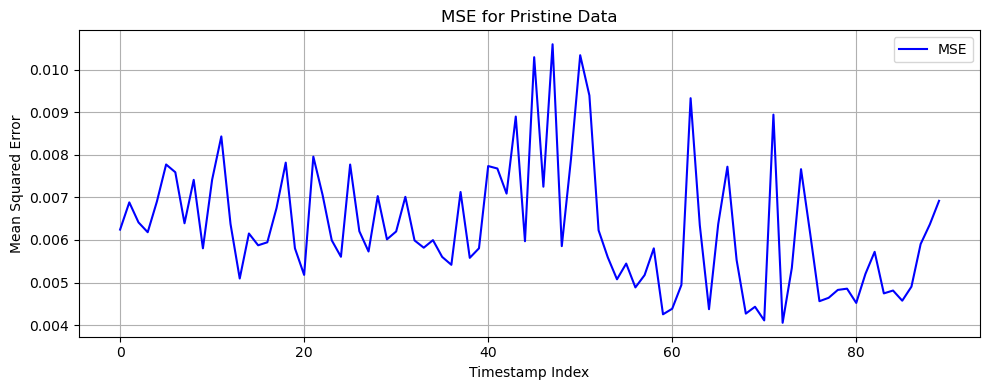

In [16]:
x_timestamps = range(len(mse))  

plt.figure(figsize=(10, 4))
plt.plot(x_timestamps, mse, label="MSE", color='blue')
plt.title("MSE for Pristine Data")
plt.xlabel("Timestamp Index")
plt.ylabel("Mean Squared Error")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

On the pristine dataset, the LSTM model demonstrated consistently low prediction error. The MSE values for all sequences ranged narrowly between 0.004 and 0.013. This small range of error indicates that the model was able to reliably capture and reproduce the normal waveform behavior. The absence of large fluctuations in MSE confirms that the model was well-trained on normal patterns and that it generalizes effectively to unseen but structurally healthy signals.

## Testing on the defected data

In [17]:
def get_index(time, date_df):
    return date_df[date_df['date'].isin(time)].index.to_numpy()

The defect signal starts from here:

In [18]:
defect_pos = int(get_index(['2021-06-08-09-15'], s_dates_df))
defect_pos

C:\Users\qq24422\AppData\Local\Temp\ipykernel_2664\4076537246.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  defect_pos = int(get_index(['2021-06-08-09-15'], s_dates_df))


76650

In [19]:
X_defect_raw = sample_training(df_real, defect_pos, 76680)
X_defect_scaled = normalize_test(X_defect_raw, scaler)
X_defect, y_defect = process_data(X_defect_scaled)

X shape: (20, 10, 6000)
y shape: (20, 6000)


In [20]:
y_defect_pred = model.predict(X_defect)
mse_defect = np.mean((y_defect - y_defect_pred) ** 2, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [21]:
mse_defect

array([0.06133622, 0.06101256, 0.05872558, 0.05574925, 0.05932694,
       0.10065563, 0.10193356, 0.10608272, 0.11108394, 0.12301824,
       0.17352412, 0.18218766, 0.18652108, 0.18657789, 0.19170632,
       0.0760932 , 0.12875259, 0.20735109, 0.20543912, 0.2008041 ])

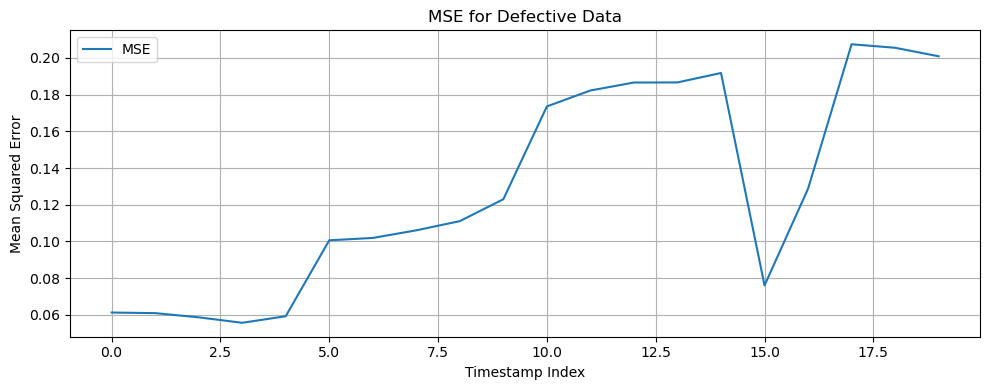

In [22]:
x_plot = range(len(mse_defect)) 
plt.figure(figsize=(10, 4))
plt.plot(x_plot, mse_defect, label="MSE")

plt.title("MSE for Defective Data")
plt.xlabel("Timestamp Index")
plt.ylabel("Mean Squared Error")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

For the defective dataset, which includes 50 consecutive data rows with a known defect beginning at row index 76650, the MSE behavior was notably different. Initially, the MSE remained at a level comparable to the pristine dataset. However, beginning around index 10 of the MSE sequence (which corresponds to the start of the defect in the original data), the prediction error exhibited a sharp and sustained increase.

In particular, MSE values rose from around 0.07 to above 0.2, indicating that the model's predictions diverged significantly from the actual signal once the waveform pattern deviated due to structural abnormalities. This sharp escalation in MSE at the correct defect onset confirms that the LSTM model not only recognizes normal behavior but also fails predictably in the presence of anomalies—making the prediction error a strong indicator of structural defects.

X shape: (56670, 10, 6000)
y shape: (56670, 6000)
1771/1771 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step


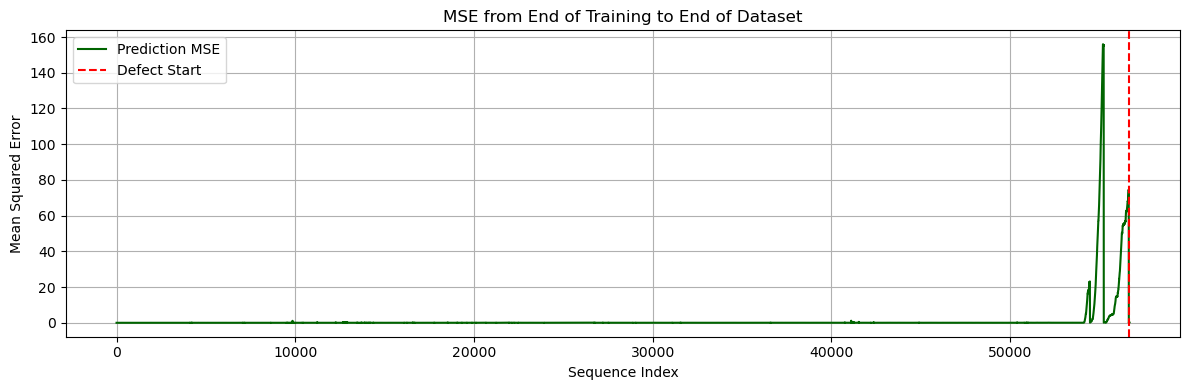

In [23]:
start_row = train_size  
end_row = df_real.shape[0].compute()  
X_full_raw = sample_training(df_real, start_row, end_row)

X_full_scaled = normalize_test(X_full_raw, scaler)

X_full, y_full = process_data(X_full_scaled)

y_full_pred = model.predict(X_full)
mse_full = np.mean((y_full - y_full_pred) ** 2, axis=1)

defect_index_in_plot = defect_pos - start_row - 10  

plt.figure(figsize=(12, 4))
plt.plot(mse_full, label="Prediction MSE", color="darkgreen")
plt.axvline(defect_index_in_plot, color='red', linestyle='--', label="Defect Start")
plt.title("MSE from End of Training to End of Dataset")
plt.xlabel("Sequence Index")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

While the LSTM model successfully identified the known defect (as evidenced by the steep MSE rise following the marked red line), a preliminary increase in prediction error was also observed just before the defect zone. This early rise aligns with a known time discontinuity in the dataset—specifically, a long interval of missing data between 2015 and 2020. Since LSTM models rely heavily on sequential continuity, such temporal gaps can disrupt the model’s learned patterns, triggering elevated MSE despite the absence of structural defects. This highlights the importance of consistent data sampling in time-series forecasting and explains the pre-defect anomaly as a result of signal discontinuity rather than physical degradation.

## Classifier with Frequency domain

In [31]:
def add_label(df, defect_id):
    
    m = len(df)
    y = np.zeros(m)
    y[defect_id:] = 1
    yint = y.astype(int)

    return yint

label = add_label(df_real, defect_pos)

In [63]:
label

array([0, 0, 0, ..., 1, 1, 1])

In [50]:
defect_idx = np.where(label == 1)[0]
normal_idx = np.where(label == 0)[0]

np.random.seed(1000)
np.random.shuffle(defect_idx)
np.random.shuffle(normal_idx)

n_defect = 30
n_normal = 45
selected_normal_idx = normal_idx[:n_normal]
selected_idx = np.concatenate([selected_normal_idx, defect_idx])
np.random.shuffle(selected_idx)

In [51]:
selected_idx

array([18467, 76668, 76673, 76667, 76654, 59309, 76664,  7310,  9019,
       16195, 76651, 27255, 53122, 26478,   570, 17674, 10545, 76676,
       75403, 44610, 25179, 39312, 58089, 56672,  2516, 76655, 76670,
       64469, 76650, 76666, 10261, 76662, 72247, 16320, 70520, 76665,
        4832, 76663, 76658, 40695, 76675, 39999, 51649, 49053, 76669,
       27765, 76656, 55275, 72634, 48121, 14224, 41316, 59289, 76671,
       76652, 76660, 31330, 76657, 67982, 76679, 28039, 76672, 76659,
       72385, 30164, 76678,  7860, 73347, 32947, 74881, 76661, 76677,
       76674,  2038, 76653], dtype=int64)